# Import Modules

In [ ]:
!pip install ultralytics supervision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 22.2 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import supervision as sv
import numpy as np
import cv2
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Load Model

In [ ]:
model = YOLO('yolov8x.pt')
model.fuse() # for faster inference

YOLOv8x summary (fused): 112 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
# dict mapping class_id to class_name
CLASS_NAMES_DICT =model.model.names

#CLASS_NAMES_DICT

In [ ]:
# class_ids of interest - car, motorcycle, bus, truck
classes = [2,3,5,7]

# Plot Frame from Video

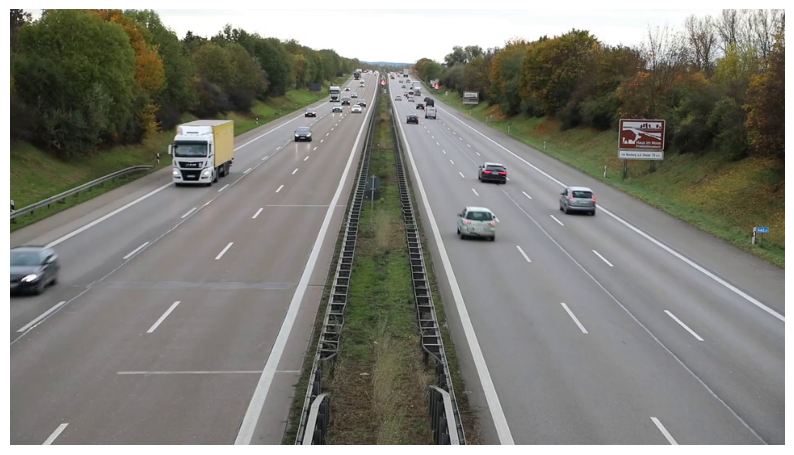

In [ ]:
# create frame generator
generator = sv.get_video_frames_generator('highway-vehicles.mp4')

# get the first frame
iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame, (10, 10))

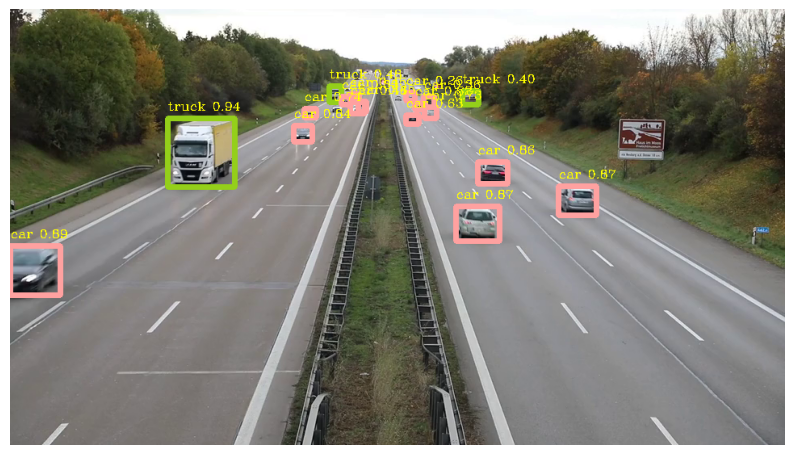

In [ ]:
# detect vehicles from the frame
results = model(frame, verbose=False)[0]

#convert to detections
detections = sv.Detections.from_ultralytics(results)
#only consider classes which we require
detection = detections[np.isin(detections.class_id, classes)]

#create instance of box annotator
box_annotator = sv.BoxAnnotator(thickness=6)
#annotate in the frame
annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detection)

# format labels
labels = []
for confidence, class_id in zip(detections.confidence, detections.class_id):
  label = f'{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}'
  labels.append(label)

#overlay labels in the boundingbox
for box, label in zip(detections.xyxy, labels):
  x1, y1, x2, y2 = box.astype(int)

  # add the label above the box
  cv2.putText(annotated_frame, label, (x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5, color=(0, 255, 255), thickness=1)

# plot image
sv.plot_image(annotated_frame, (10,10))

# Track and Count Vehicles

In [ ]:
sv.VideoInfo.from_video_path('highway-vehicles.mp4')

VideoInfo(width=960, height=540, fps=25, total_frames=1060)

In [ ]:
# line config
LINE_START = sv.Point(0, 500)
LINE_END = sv.Point(1280, 500)

# create bytetracker instance
byte_tracker = sv.ByteTrack(frame_rate=25)

#create linezone counter instance
line_counter = sv.LineZone(start=LINE_START, end=LINE_END)

#create linezone annotator
line_zone_annotator = sv.LineZoneAnnotator(thickness=2, text_scale=0.5)

#create box annotator
box_annotator = sv.BoxAnnotator(thickness=2)

#create trace annotator
trace_annotator = sv.TraceAnnotator(thickness=2, trace_length=50)


In [ ]:
# define the function for processing frames
def process_frame(frame):
  #get results from model
  results = model(frame, verbose=False)[0]
  #convert to detections
  detections = sv.Detections.from_ultralytics(results)
  #only consider classes which we require
  detections = detections[np.isin(detections.class_id, classes)]
  #tracking detections
  detections = byte_tracker.update_with_detections(detections)

  #create labels
  labels = []
  for confidence, class_id, tracker_id in zip(
    detections.confidence, detections.class_id, detections.tracker_id
):
    label = f'{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}'
    labels.append(label)

  #update trace annotator
  annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)
  #update box annotator
  annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

  #overlay labels in the boundingbox
  for box, label in zip(detections.xyxy, labels):
    x1, y1, x2, y2 = box.astype(int)

    # add the label above the box
    cv2.putText(annotated_frame, label, (x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5, color=(0, 255, 255), thickness=1)

  line_counter.trigger(detections)
  #update line zone annotator
  annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_counter)

  return annotated_frame

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
# run the program
video_path = 'highway-vehicles.mp4'
#get input from videocam
#video_cap = cv2.VideoCapture(0)
#get input from video
video_cap = cv2.VideoCapture(video_path)

while True:
  success, frame = video_cap.read()
  if not success:
    break
  #resize frame
  frame = cv2.resize(frame, (1280, 720))
  #convert to RGB
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  #process frame
  processed_frame = process_frame(frame)
  #display frame
  cv2_imshow(processed_frame)

  #exit if any key pressed
  if cv2.waitKey(1) & 0xFF != 255:
    break

video_cap.release()
cv2.destroyAllWindows

In [15]:
output_video_path = 'highway_vehicles_output.mp4'
video_info = sv.VideoInfo.from_video_path('highway-vehicles.mp4')

# The instructions specify using 1280x720 for the output video dimensions
output_width = 1280
output_height = 720
output_fps = video_info.fps

print(f"Output video path: {output_video_path}")
print(f"Output resolution: {output_width}x{output_height}")
print(f"Output FPS: {output_fps}")

Output video path: highway_vehicles_output.mp4
Output resolution: 1280x720
Output FPS: 25


In [16]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_video = cv2.VideoWriter(output_video_path, fourcc, output_fps, (output_width, output_height))

print(f"VideoWriter initialized for output video: {output_video_path}")

VideoWriter initialized for output video: highway_vehicles_output.mp4


In [17]:
video_cap = cv2.VideoCapture(video_path)

while True:
  success, frame = video_cap.read()
  if not success:
    break
  #resize frame
  frame = cv2.resize(frame, (output_width, output_height))
  #convert to RGB to BGR for OpenCV VideoWriter
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
  #process frame
  processed_frame = process_frame(frame)
  # Write the processed frame to the output video
  out_video.write(processed_frame)

video_cap.release()
out_video.release()
cv2.destroyAllWindows()

print(f"Processed video saved to: {output_video_path}")

Processed video saved to: highway_vehicles_output.mp4
